# Imports and Variables 

In [1]:
#variables 
import os 

SEQ_LEN = 1024 

BATCH_SIZE = 8


#PATHS 

LOAD_BACKBONE_FROM = '../input/backbone/'
LOAD_MODEL_WEIGHTS_FROM = '../input/mymodel/mymodel'
LOAD_TXT_FROM = '../input/feedback-prize-2021/test/'

#GPU and info message for tf
os.environ["CUDA_VISIBLE_DEVICES"]='0' 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# canonicals 
import pandas as pd 
import numpy as np 

#deep
import tensorflow as tf
from transformers import TFAutoModel, AutoConfig, AutoTokenizer

# Loading and preprocessing data

In [3]:
txt_ids = [f.split('.')[0] for f in os.listdir(LOAD_TXT_FROM)]
df_test = pd.DataFrame(txt_ids,columns=['id'])
df_test

,id
0,0FB0700DAF44
1,D72CB1C11673
2,18409261F5C2
3,DF920E0A7337
4,D46BCB48440A


In [4]:
def get_essay(id_):
    """Function to get the full text of an essay from the .txt file.

    Args:
        id_ (str): id of the essay
        mode (str, optional): determines whether to access *train* or *test* texts. \
        Defaults to 'train'.

    Returns:
        str: Returns the full text of the id
    """
    with open(os.path.join(LOAD_TXT_FROM,f'{id_}.txt'),'r') as file:
        txt = file.read()
        return txt.strip()

In [5]:
# store text in df
df_test['essays'] = df_test['id'].apply(get_essay)

# Tokenize texts

## Tokenizer

In [6]:
def tokenize_labelize(essay,tokenizer,predictionstring=None,labels=None,max_len=SEQ_LEN):
    """Tokenize an essay and match each token with the corresponding label.

    Args:
        essay (str): Text to tokenize
        tokenizer (tokenizer): Tokenizer from HF.
        predictionstring (pandas.Series | numpy.array, optional): As a unique string, list of index position of words with a label. Must be provided with labels. Defaults to None.
        labels (pandas.Series | numpy.array, optional): As a unique string, list of labels of each word. Must be provided with labels. Defaults to None.
        max_len (int): Maximum sequence length for padding/truncating.
        

    Returns:
        dict : Returns a dictionnary with input_ids,attention_mask and labels if passed.
    """
    
    tokens = tokenizer(essay,
                       return_attention_mask = True,
                       return_token_type_ids = False,
                       padding = 'max_length',
                       max_length = SEQ_LEN,
                       truncation = True,
                       return_tensors='np'
                      )
    
    word_ids=tokens.word_ids()
    
    labels_mapping = {
                      'B-Lead' : 0,
                      'B-Position' : 1,
                      'B-Evidence' : 2,
                      'B-Claim' : 3,
                      'B-Concluding_Statement' : 4,
                      'B-Counterclaim' : 5,
                      'B-Rebuttal' : 6,
                      'I-Lead' : 7,
                      'I-Position' : 8,
                      'I-Evidence' : 9,
                      'I-Claim' : 10,
                      'I-Concluding_Statement' : 11,
                      'I-Counterclaim' : 12,
                      'I-Rebuttal': 13
                        }
    
    if labels:
        match = {p:labels_mapping[l] for p,l in zip(predictionstring,labels)}
        labels_matched = [15 if (w==None or w==word_ids[i-1]) \
                            else match.get(str(w),14) \
                            for i,w in enumerate(word_ids)]
                            
        
        return {
        'input_ids' : tokens['input_ids'][0],
        'attention_mask' : tokens['attention_mask'][0],
        'labels': np.array(labels_matched), 
        'predictionstring':np.array(word_ids)
        }
    
    return {
        'input_ids' : tokens['input_ids'][0],
        'attention_mask' : tokens['attention_mask'][0],
        'predictionstring':np.array(word_ids)
        }

In [7]:
## vectorize the function tokenizer above
tokenize_labelize_vect = np.vectorize(tokenize_labelize,excluded=['SEQ_LEN'],otypes=['object'])

In [8]:
## load tokenizer
tokenizer = AutoTokenizer.from_pretrained(LOAD_BACKBONE_FROM)

In [9]:
#create tokens
tokens_test = tokenize_labelize_vect(df_test.essays,tokenizer,max_len=SEQ_LEN)

## Dataset creation

In [10]:
def dataset_creator(tokens):
    """
    Creates a dictionnary with tokens attributes as a numpy array.

    Args:
        tokens (list): list of dictionnaries, outputs from tokeniner

    Returns:
        dict: dict with list of size BATCH_SIZE of inputs_id, attention mask, predictionstring and labels if provided.
    """
    
    keys = tokens[0].keys()

    inputs = {
        'input_ids':[],
        'attention_mask':[]
        }
    predictionstring = []
    labels = []
       
    for t in tokens:
        inputs['input_ids'].append(t['input_ids'])
        inputs['attention_mask'].append(t['attention_mask'])
        predictionstring.append(t['predictionstring'])
        if 'labels' in keys:
                labels.append(t['labels'])

        
    inputs['input_ids'] = np.array(inputs['input_ids'])
    inputs['attention_mask'] = np.array(inputs['attention_mask'])
    predictionstring = np.array(predictionstring)
    labels = np.array(labels)
    
    if 'labels' in tokens[0].keys():
        
        #OHE labels
        labels_ohe = np.zeros((len(labels),SEQ_LEN,16))
        
        dim1 = np.arange(len(labels))
        dim2 = np.arange(SEQ_LEN)
        
        labels_ohe[dim1[:,None,None],dim2[None,:,None],labels[:,:,None]] = 1
        
        return inputs, labels_ohe, predictionstring
    
    return inputs, predictionstring

In [11]:
## creating test dataset
X_test,ps_test = dataset_creator(tokens_test)

# Model prediction

## Model architecture

In [12]:
## Instantiate model Longformer to be used as backbone
config = AutoConfig.from_pretrained(os.path.join(LOAD_BACKBONE_FROM,'config.json'))
backbone = TFAutoModel.from_pretrained(os.path.join(LOAD_BACKBONE_FROM,'tf_model.h5'),config=config)

All model checkpoint layers were used when initializing TFLongformerModel.

All the layers of TFLongformerModel were initialized from the model checkpoint at ../input/backbone/tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


In [13]:
def init_model():
    input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,),dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(SEQ_LEN,),dtype='int32')
    
    x = backbone({'input_ids':input_ids,
                 'attention_mask':attention_mask})[0]

    backbone.trainable = False


    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 512,
                                                           activation = 'tanh',
                                                           dropout=.2,
                                                           return_sequences=True))(x)
    x_res = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = 512,
                                                           activation = 'tanh',
                                                           dropout=.2,
                                                           return_sequences=True))(x)
    

    x = tf.keras.layers.add([x,x_res])
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16,activation = 'softmax'))(x)

    model = tf.keras.models.Model(inputs={'input_ids':input_ids,
                                          'attention_mask':attention_mask},outputs=output)
    
    
    return model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


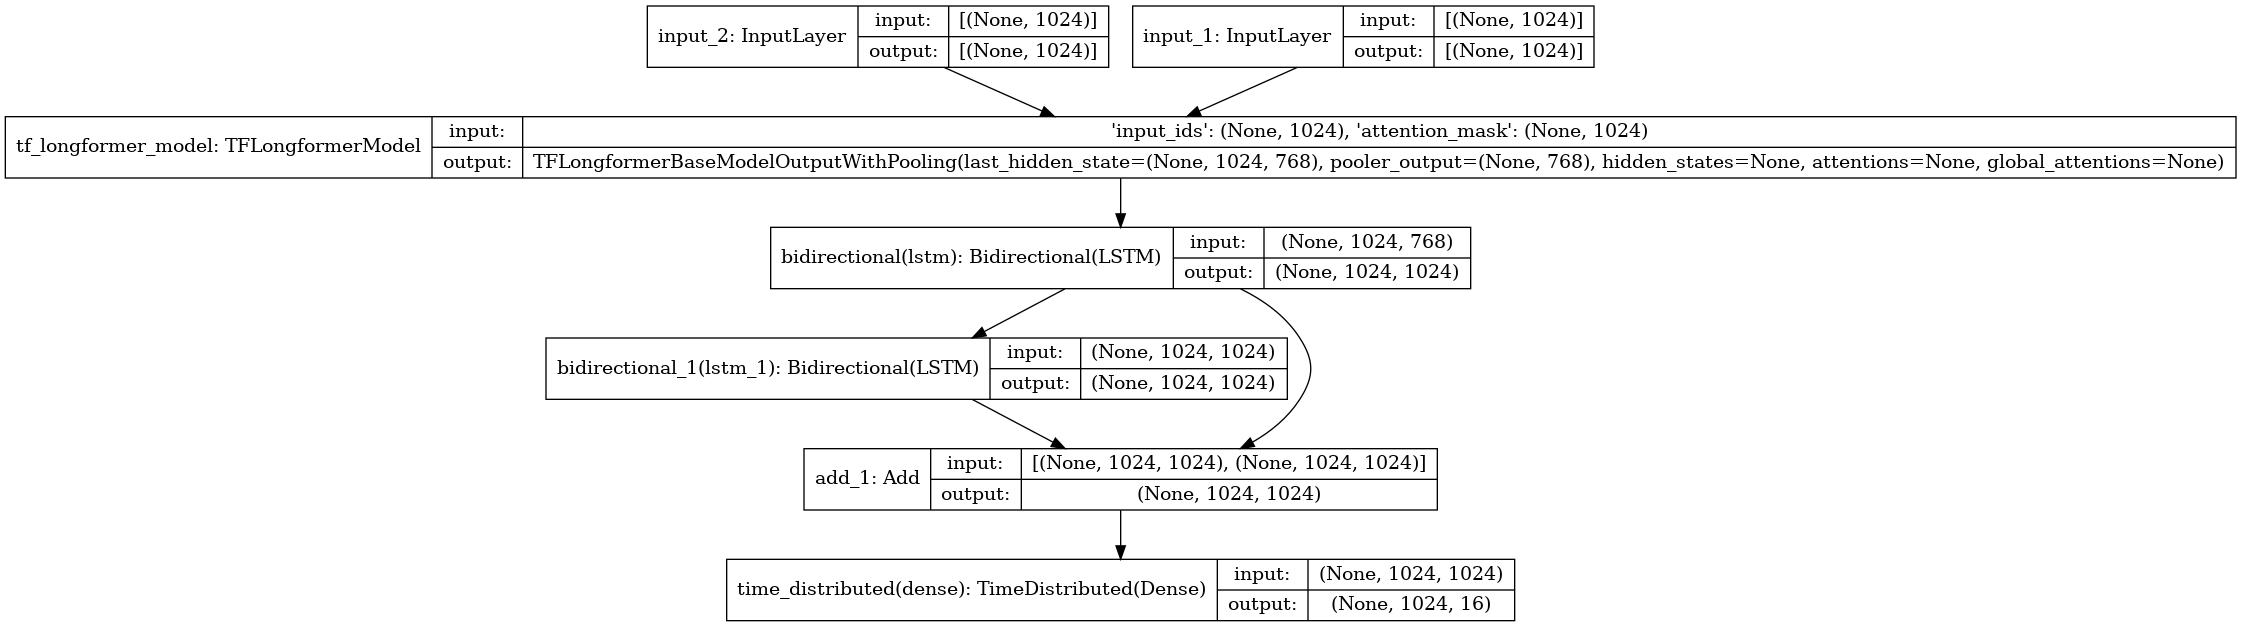

In [14]:
## instantiate the model, plot the graph
model = init_model()

tf.keras.utils.plot_model(model,show_shapes=True)

## Model compilation

In [15]:
# creating homemade metric

def accuracy_masked_func(y_true,y_pred):
    y_pred = tf.cast(tf.argmax(y_pred,axis=-1),'int32')
    y_true = tf.cast(y_true,'int32')
    y_true = tf.cast(tf.argmax(y_true,axis=-1),'int32') #for y_pred and y_true to match
    mask = tf.cast(y_true != 15,'int32') #create a mask
    matches = tf.cast(tf.equal(y_true,y_pred),'int32')*mask #calculate the matches ignoring the masking
    accuracy = tf.math.reduce_sum(matches,axis=-1)/tf.maximum(tf.math.reduce_sum(mask,axis=-1),1)
    
    return accuracy

In [16]:
# define loss and metrics 
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
masked_accuracy = tf.keras.metrics.MeanMetricWrapper(fn=accuracy_masked_func)

# RMSProp optimizer with clip value and small lr to avoid exploiding gradient 
opt = tf.keras.optimizers.RMSprop(clipvalue=.5,learning_rate=0.0001)

#compile
model.compile(optimizer=opt,loss=loss,metrics=[cat_accuracy,masked_accuracy])

## Load model pretrained weights

In [17]:
model.load_weights(os.path.join(LOAD_MODEL_WEIGHTS_FROM))

# Get predictions

In [18]:
y_pred = model.predict(X_test,batch_size=BATCH_SIZE)

In [19]:
labels_mapping = {'B-Lead' : 0,
                  'B-Position' : 1,
                  'B-Evidence' : 2,
                  'B-Claim' : 3,
                  'B-Concluding_Statement' : 4,
                  'B-Counterclaim' : 5,
                  'B-Rebuttal' : 6,
                  'I-Lead' : 7,
                  'I-Position' : 8,
                  'I-Evidence' : 9,
                  'I-Claim' : 10,
                  'I-Concluding_Statement' : 11,
                  'I-Counterclaim' : 12,
                  'I-Rebuttal': 13,
                 'O':14,
                 'PAD':15}

reversed_mapping = {v:(k[2:] if v<14 else k) for k,v in labels_mapping.items()}

In [20]:
def get_preds(y_pred,ps):
    """
    Generate readable predictions from the output of the model.

    Args:
        y_pred (ndarray): output of the model
        ps (ndarray): predictionstring referring to the token predicted

    Returns:
        DataFrame : DataFrame with class and predictionstrings
    """
    
    labels = []
    predictionstrings = []
    counts = []
    
    counter=dict()
    
    for tok,pos in zip(y_pred,ps):
        
        if tok <= 13:
            lab = reversed_mapping[tok]
            labels.append(lab)
            predictionstrings.append(pos)
            if len(labels)<2:
                counts.append(str(1))
                counter.setdefault(lab,1)
                continue
            if lab == labels[-2]:
                counts.append(str(counter[lab]))
            else: 
                try:
                    counter[lab]+=1
                except KeyError:
                    counter.setdefault(lab,1)
                counts.append(str(counter[lab]))
    
    preds = pd.DataFrame([labels,counts,predictionstrings],index=['class','count','predictionstring']).T
    preds['class'] += ' ' + preds['count'].astype(str)
    preds = preds.groupby('class',sort=False).agg({'predictionstring':list}).reset_index()
    preds['class']=preds['class'].apply(lambda txt : txt.split()[0])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : [str(l) for l in l_])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : ' '.join(l_))
    
    return preds

In [21]:
preds = np.argmax(y_pred,axis=-1)
preds_df = pd.DataFrame()

for i,idx in enumerate(df_test.index): 
    
    pred_ = get_preds(preds[i],ps_test[i])
    
    pred_['id']=df_test.iloc[idx]['id']
    
    preds_df = preds_df.append(pred_)


# Submission

In [22]:
sub = preds_df[['id','class','predictionstring']]
sub['class'] = sub['class'].replace('Concluding_Statement','Concluding Statement')
sub.reset_index(inplace=True,drop=True)
sub.to_csv('submission.csv',index=False)